## Hidden Markov Model of Diachronic Semantic Change

In accordance with Van de Velde & De Smet (2021)
https://www.tandfonline.com/doi/full/10.1080/09296174.2021.1877004

In [1]:
# import dependencies
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# create state space and initial stage probabilities

states = ['exophoric', 'anaphoric']
pi = [0.5, 0.5]
state_space = pd.Series(pi, index=states, name='states')
print(state_space)
print(state_space.sum())

exophoric    0.5
anaphoric    0.5
Name: states, dtype: float64
1.0


In [89]:
# create transition matrix
# equals transition probability matrix of changing states given a state 
# matrix is size (M x M) where M is number of states 
q_df = pd.DataFrame(columns = states, index = states)
q_df.loc[states[0]] = [0.7, 0.3]
q_df.loc[states[1]] = [0.1, 0.9]

print(q_df)

q = q_df.values
print('\n', q, q.shape, '\n')
print(q_df.sum(axis=1))

          exophoric anaphoric
exophoric       0.7       0.3
anaphoric       0.1       0.9

 [[0.7 0.3]
 [0.1 0.9]] (2, 2) 

exophoric    1.0
anaphoric    1.0
dtype: float64


In [90]:
from pprint import pprint 

# create a function that maps transition probability dataframe to markov edges and weights
def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

{('anaphoric', 'anaphoric'): 0.9,
 ('anaphoric', 'exophoric'): 0.1,
 ('exophoric', 'anaphoric'): 0.3,
 ('exophoric', 'exophoric'): 0.7}


In [91]:
# create hidden transition matrix
# alpha = trnasition probability matrix
a_df = q_df

print(a_df)

a = a_df.values

print('\n', a, a.shape, '\n')
print(a_df.sum(axis=1))

          exophoric anaphoric
exophoric       0.7       0.3
anaphoric       0.1       0.9

 [[0.7 0.3]
 [0.1 0.9]] (2, 2) 

exophoric    1.0
anaphoric    1.0
dtype: float64


In [99]:
#create matrix of emission probabilities 
#beta = observation probabilities given states 
# matrix is size (M x O) where M is number of states 
# and O is number of different possible observations

emissions = ['this', 'that', 'pro']

b_df = pd.DataFrame(columns = emissions, index = states)
b_df.loc[states[0]] = [0.3, 0.7, 0.0]
b_df.loc[states[1]] = [0.1, 0.3, 0.6]

print(b_df)

b = b_df.values
print('\n', b, b.shape, '\n')
print(b_df.sum(axis=1))

          this that  pro
exophoric  0.3  0.7  0.0
anaphoric  0.1  0.3  0.6

 [[0.3 0.7 0.0]
 [0.1 0.3 0.6]] (2, 3) 

exophoric    1.0
anaphoric    1.0
dtype: float64


In [100]:
# create graph edges and weights
hide_edges_wts = _get_markov_edges(a_df)
pprint(hide_edges_wts)

emit_edges_wts = _get_markov_edges(b_df)
pprint(emit_edges_wts)

{('anaphoric', 'anaphoric'): 0.9,
 ('anaphoric', 'exophoric'): 0.1,
 ('exophoric', 'anaphoric'): 0.3,
 ('exophoric', 'exophoric'): 0.7}
{('anaphoric', 'pro'): 0.6,
 ('anaphoric', 'that'): 0.3,
 ('anaphoric', 'this'): 0.1,
 ('exophoric', 'pro'): 0.0,
 ('exophoric', 'that'): 0.7,
 ('exophoric', 'this'): 0.3}


Nodes:
['exophoric', 'anaphoric']

Edges:
OutMultiEdgeDataView([('exophoric', 'exophoric', {'weight': 0.7, 'label': 0.7}), ('exophoric', 'anaphoric', {'weight': 0.3, 'label': 0.3}), ('exophoric', 'this', {'weight': 0.3, 'label': 0.3}), ('exophoric', 'that', {'weight': 0.7, 'label': 0.7}), ('exophoric', 'pro', {'weight': 0.0, 'label': 0.0}), ('anaphoric', 'exophoric', {'weight': 0.1, 'label': 0.1}), ('anaphoric', 'anaphoric', {'weight': 0.9, 'label': 0.9}), ('anaphoric', 'this', {'weight': 0.1, 'label': 0.1}), ('anaphoric', 'that', {'weight': 0.3, 'label': 0.3}), ('anaphoric', 'pro', {'weight': 0.6, 'label': 0.6})])


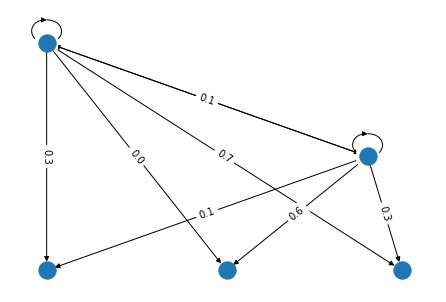

In [107]:
# create graph object 
G = nx.MultiDiGraph()

# nodes correspond to states 
G.add_nodes_from(states)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent hidden probabilities
for k, v in hide_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

# edges represent emission probabilities
for k, v in emit_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

print(f'Edges:')
pprint(G.edges(data=True))

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog = 'dot')

nx.draw(G, pos)

# create edge labels for jupyter plot but is not necessary
emit_edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=emit_edge_labels)

plt.show()

In [102]:
# observation map of utterance and state 
obs_map = {'this': 0, 'that':1, 'pro':2}
obs = np.array([1,1,2,1,0,1,2,1,0,2,2,0,1,0,1])

inv_obs_map = dict((v,k) for k, v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(obs)]

print( pd.DataFrame(np.column_stack([obs, obs_seq]), 
                   columns = ['Obs_code', 'Obs_seq']))

   Obs_code Obs_seq
0         1    that
1         1    that
2         2     pro
3         1    that
4         0    this
5         1    that
6         2     pro
7         1    that
8         0    this
9         2     pro
10        2     pro
11        0    this
12        1    that
13        0    this
14        1    that


In [103]:
# define Viterbi algorithm for shortest path 

def viterbi(pi, a, b, obs):
    
    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]
    
    # init blank path
    path = np.zeros(T)
    # delta --> highest probability of any path that reaches state i
    delta = np.zeros((nStates, T))
    # phi --> argmax by time step for each state
    phi = np.zeros((nStates, T))
    
    # init delta and phi 
    delta[:, 0] = pi * b[:, obs[0]]
    phi[:, 0] = 0

    print('\nStart Walk Forward\n')    
    # the forward algorithm extension
    for t in range(1, T):
        for s in range(nStates):
            delta[s, t] = np.max(delta[:, t-1] * a[:, s]) * b[s, obs[t]] 
            phi[s, t] = np.argmax(delta[:, t-1] * a[:, s])
            print('s={s} and t={t}: phi[{s}, {t}] = {phi}'.format(s=s, t=t, phi=phi[s, t]))
    
    # find optimal path
    print('-'*50)
    print('Start Backtrace\n')
    path[T-1] = np.argmax(delta[:, T-1])
    #p('init path\n    t={} path[{}-1]={}\n'.format(T-1, T, path[T-1]))
    for t in range(T-2, -1, -1):
        index1 = int(path[t+1])
        index2 = int(t+1)
        path[t] = phi[index1, index2]
        #p(' '*4 + 't={t}, path[{t}+1]={path}, [{t}+1]={i}'.format(t=t, path=path[t+1], i=[t+1]))
        print('path[{}] = {}'.format(t, path[t]))
        
    return path, delta, phi

path, delta, phi = viterbi(pi, a, b, obs)
print('\nsingle best state path: \n', path)
print('delta:\n', delta)
print('phi:\n', phi)


Start Walk Forward

s=0 and t=1: phi[0, 1] = 0.0
s=1 and t=1: phi[1, 1] = 1.0
s=0 and t=2: phi[0, 2] = 0.0
s=1 and t=2: phi[1, 2] = 0.0
s=0 and t=3: phi[0, 3] = 1.0
s=1 and t=3: phi[1, 3] = 1.0
s=0 and t=4: phi[0, 4] = 0.0
s=1 and t=4: phi[1, 4] = 1.0
s=0 and t=5: phi[0, 5] = 0.0
s=1 and t=5: phi[1, 5] = 1.0
s=0 and t=6: phi[0, 6] = 0.0
s=1 and t=6: phi[1, 6] = 1.0
s=0 and t=7: phi[0, 7] = 1.0
s=1 and t=7: phi[1, 7] = 1.0
s=0 and t=8: phi[0, 8] = 0.0
s=1 and t=8: phi[1, 8] = 1.0
s=0 and t=9: phi[0, 9] = 0.0
s=1 and t=9: phi[1, 9] = 1.0
s=0 and t=10: phi[0, 10] = 1.0
s=1 and t=10: phi[1, 10] = 1.0
s=0 and t=11: phi[0, 11] = 1.0
s=1 and t=11: phi[1, 11] = 1.0
s=0 and t=12: phi[0, 12] = 0.0
s=1 and t=12: phi[1, 12] = 1.0
s=0 and t=13: phi[0, 13] = 0.0
s=1 and t=13: phi[1, 13] = 1.0
s=0 and t=14: phi[0, 14] = 0.0
s=1 and t=14: phi[1, 14] = 1.0
--------------------------------------------------
Start Backtrace

path[13] = 0.0
path[12] = 0.0
path[11] = 0.0
path[10] = 1.0
path[9] = 1.0
path[

In [104]:
state_map = {0:'exophoric', 1:'anaphoric'}
state_path = [state_map[v] for v in path]

(pd.DataFrame()
 .assign(Observation=obs_seq)
 .assign(Best_Path=state_path))

,Observation,Best_Path
0,that,exophoric
1,that,exophoric
2,pro,anaphoric
3,that,anaphoric
4,this,anaphoric
5,that,anaphoric
6,pro,anaphoric
7,that,anaphoric
8,this,anaphoric
9,pro,anaphoric
